In [1]:
import warnings 
warnings.filterwarnings("ignore")

#data wrangling and pre-processing
import pandas as pd
import numpy as np

#data visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
import pickle

#model validation
from sklearn.metrics import log_loss, roc_auc_score,f1_score,recall_score,roc_curve,auc,precision_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, fbeta_score, matthews_corrcoef
from sklearn import metrics

#cross validation
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

#normalize numeric values
from sklearn.preprocessing import StandardScaler

#machine learning algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV

In [2]:
df=pd.read_csv("heart_statlog_cleveland_hungary_final.csv")

In [3]:
df=df.rename(columns={"chest pain type":"chest_pain_type", "resting bp s":"resting_blood_pressure", 
             
"fasting blood sugar":"fasting_blood_sugar", "resting ecg":"rest_ecg", "max heart rate":"max_heart_rate",
             "exercise angina":"exercise_angina","oldpeak":"st_depression", "ST slope":"st_slope"})

In [4]:
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,rest_ecg,max_heart_rate,exercise_angina,st_depression,st_slope,target
0,40,1,2,140,289,0,0,172,0,0.0,1,0
1,49,0,3,160,180,0,0,156,0,1.0,2,1
2,37,1,2,130,283,0,1,98,0,0.0,1,0
3,48,0,4,138,214,0,0,108,1,1.5,2,1
4,54,1,3,150,195,0,0,122,0,0.0,1,0


In [5]:
#converting features to categorical features

df["chest_pain_type"][df["chest_pain_type"]==1]="typical_angina"
df["chest_pain_type"][df["chest_pain_type"]==2]="atypical_angina"
df["chest_pain_type"][df["chest_pain_type"]==3]="nonangnal_pain"
df["chest_pain_type"][df["chest_pain_type"]==4]="asymptomatic"

df["rest_ecg"][df["rest_ecg"]==0]="normal"
df["rest_ecg"][df["rest_ecg"]==1]="ST_T_wave_abnormality"
df["rest_ecg"][df["rest_ecg"]==2]="left_ventricular_hypertrophy"

df["st_slope"][df["st_slope"]==1]="upsloping"
df["st_slope"][df["st_slope"]==2]="flat"
df["st_slope"][df["st_slope"]==3]="downsloping"

df["sex"]=df.sex.apply(lambda x:"male" if x==1 else "female")

In [6]:
df.st_slope.value_counts()

flat           582
upsloping      526
downsloping     81
0                1
Name: st_slope, dtype: int64

In [7]:
df.drop(df[df["st_slope"]==0].index, inplace=True)

In [8]:
df.isnull().sum()

age                       0
sex                       0
chest_pain_type           0
resting_blood_pressure    0
cholesterol               0
fasting_blood_sugar       0
rest_ecg                  0
max_heart_rate            0
exercise_angina           0
st_depression             0
st_slope                  0
target                    0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1189 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     1189 non-null   int64  
 1   sex                     1189 non-null   object 
 2   chest_pain_type         1189 non-null   object 
 3   resting_blood_pressure  1189 non-null   int64  
 4   cholesterol             1189 non-null   int64  
 5   fasting_blood_sugar     1189 non-null   int64  
 6   rest_ecg                1189 non-null   object 
 7   max_heart_rate          1189 non-null   int64  
 8   exercise_angina         1189 non-null   int64  
 9   st_depression           1189 non-null   float64
 10  st_slope                1189 non-null   object 
 11  target                  1189 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 120.8+ KB


#### Exploratory data analysis

In [10]:
df.describe()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate,exercise_angina,st_depression,target
count,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000,1189.000000
mean,53.708158,132.138772,210.376787,0.212784,139.739277,0.387721,0.923549,0.528175
std,9.352961,18.369251,101.462185,0.409448,25.527386,0.487435,1.086464,0.499416
min,28.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000
25%,47.000000,120.000000,188.000000,0.000000,121.000000,0.000000,0.000000,0.000000
50%,54.000000,130.000000,229.000000,0.000000,141.000000,0.000000,0.600000,1.000000
75%,60.000000,140.000000,270.000000,0.000000,160.000000,1.000000,1.600000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,1.000000,6.200000,1.000000


In [11]:
df.describe(include=["O"])

,sex,chest_pain_type,rest_ecg,st_slope
count,1189,1189,1189,1189
unique,2,4,3,3
top,male,asymptomatic,normal,flat
freq,908,625,683,582


### Distribution of Heart disease

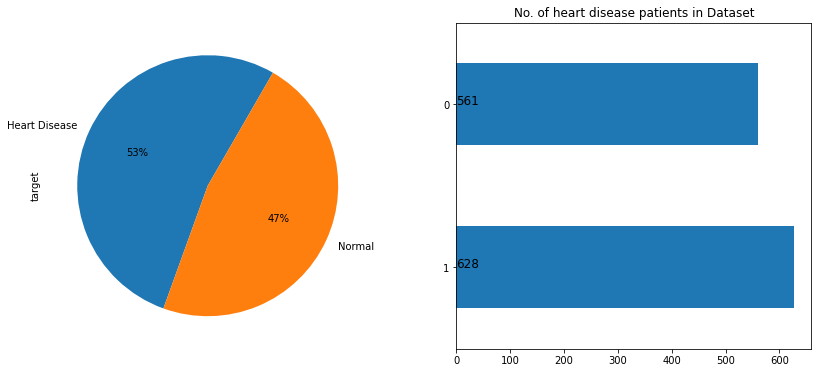

In [12]:
fig,(ax1, ax2)=plt.subplots(nrows=1, ncols=2, sharey=False, figsize=(14,6))

ax1=df["target"].value_counts().plot.pie(x="Heart disease", y="no. of patients", autopct="%1.0f%%",
                                         labels=["Heart Disease", "Normal"], startangle=60, ax=ax1);

ax2=df["target"].value_counts().plot(kind="barh", ax=ax2)
for i,j in enumerate(df["target"].value_counts().values):
    ax2.text(.5,i,j,fontsize=12)
ax2.set(title="No. of heart disease patients in Dataset")
plt.show()

The dataset is balanced having 628 heart disease patients and 561 normal patients

###### Checking Gender and Age Distribution

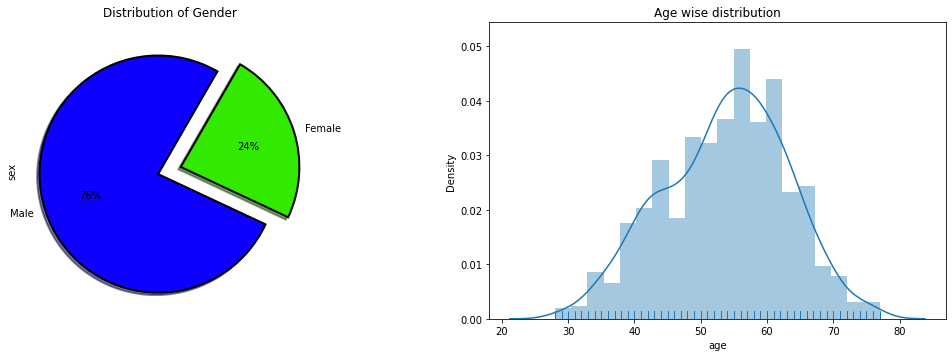

In [13]:
plt.figure(figsize=(18,12))
plt.subplot(221)
df["sex"].value_counts().plot.pie(autopct = "%1.0f%%",colors = sns.color_palette("prism",5),startangle = 60,labels=["Male","Female"],
wedgeprops={"linewidth":2,"edgecolor":"k"},explode=[.1,.1],shadow =True)
plt.title("Distribution of Gender")
plt.subplot(222)
ax= sns.distplot(df['age'], rug=True)
plt.title("Age wise distribution")
plt.show()

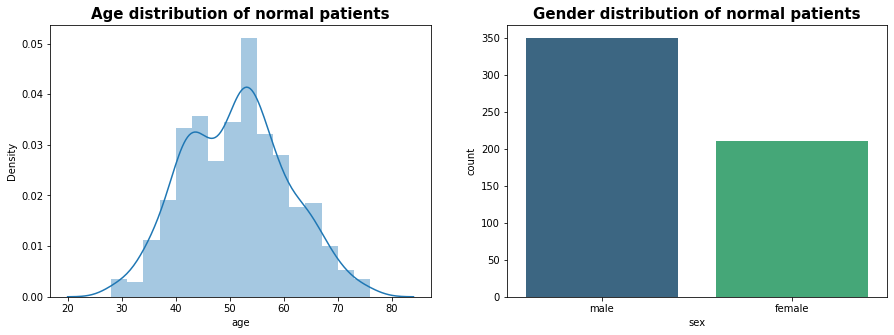

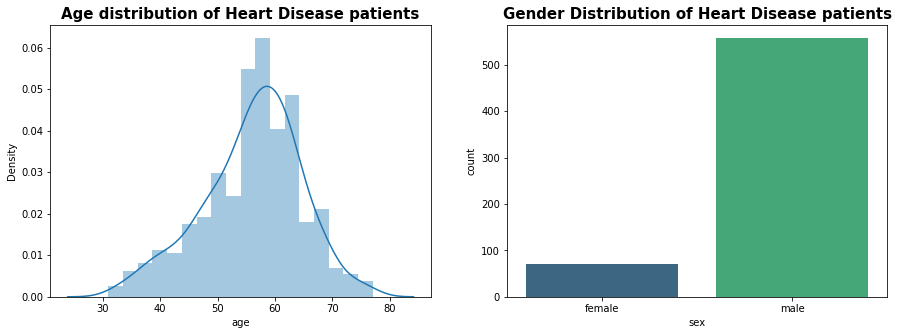

In [14]:
#creating seperate df for normal and heart patients

attr_1=df[df["target"]==1]
attr_0=df[df["target"]==0]

#plotting for normal patients
fig=plt.figure(figsize=(15,5))
ax1=plt.subplot2grid((1,2),(0,0))
sns.distplot(attr_0["age"])
plt.title("Age distribution of normal patients", fontsize=15, weight="bold")

ax1=plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_0["sex"], palette="viridis")
plt.title("Gender distribution of normal patients", fontsize=15, weight="bold")
plt.show()

##plotting heart patients
fig=plt.figure(figsize=(15,5))
ax1=plt.subplot2grid((1,2),(0,0))
sns.distplot(attr_1["age"])
plt.title("Age distribution of Heart Disease patients", fontsize=15, weight="bold")

ax1=plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_1["sex"], palette="viridis")
plt.title("Gender Distribution of Heart Disease patients", fontsize=15, weight="bold")
plt.show()

##### Distribution of Chest Pain Type

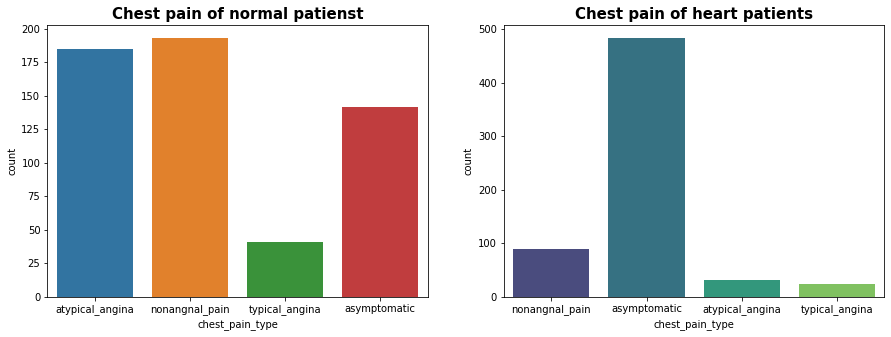

In [15]:
#Plotting normal patients
fig=plt.figure(figsize=(15,5))
ax1=plt.subplot2grid((1,2),(0,0))
sns.countplot(attr_0["chest_pain_type"])
plt.title("Chest pain of normal patienst", fontsize=15, weight="bold")

#plotting heart patients
fig=plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_1["chest_pain_type"], palette="viridis")
plt.title("Chest pain of heart patients", fontsize=15, weight="bold")
plt.show()

In [16]:
#Exploring the heart disease patients based on chest pain type
plot_criteria=["chest_pain_type","target"]
cm=sns.light_palette("red", as_cmap=True)
(round(pd.crosstab(df[plot_criteria[0]], df[plot_criteria[1]], normalize="columns")*100,2)).style.background_gradient(cmap=cm)

target,0,1
chest_pain_type,,
asymptomatic,25.310000,76.910000
atypical_angina,32.980000,4.940000
nonangnal_pain,34.400000,14.170000
typical_angina,7.310000,3.980000


76% of the chest pain type of the heart disease patients have asymptomatic chest pain

##### Distribution of Rest ECG

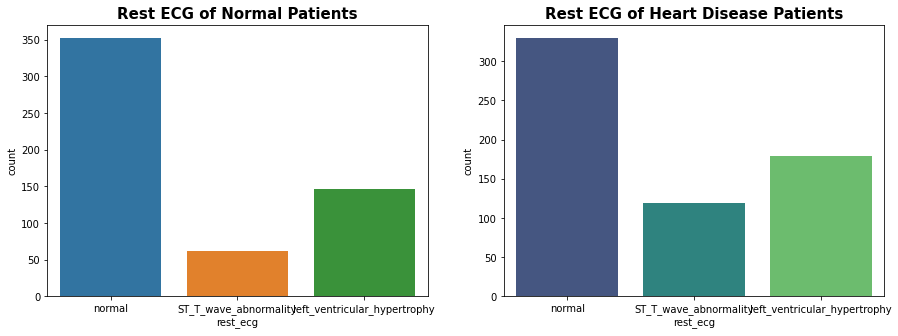

In [17]:
##plotting normal patients
fig=plt.figure(figsize=(15,5))
ax1=plt.subplot2grid((1,2),(0,0))
sns.countplot(attr_0["rest_ecg"])
plt.title("Rest ECG of Normal Patients", fontsize=15, weight="bold")

#plotting heart patients
ax1=plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_1["rest_ecg"], palette="viridis")
plt.title("Rest ECG of Heart Disease Patients", fontsize=15, weight="bold")
plt.show()

In [18]:
##Exploring heart disease patients based on rest ECG
plot_criteria=["rest_ecg","target"]
cm=sns.light_palette("red", as_cmap=True)
(round(pd.crosstab(df[plot_criteria[0]], df[plot_criteria[1]], normalize="columns")*100,2)).style.background_gradient(cmap=cm)

target,0,1
rest_ecg,,
ST_T_wave_abnormality,11.050000,18.950000
left_ventricular_hypertrophy,26.020000,28.500000
normal,62.920000,52.550000


##### Distribution of ST_Slope

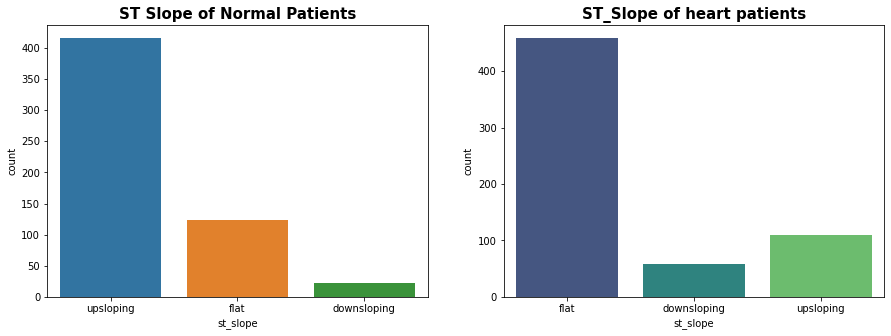

In [19]:
#plotting normal patients
fig=plt.figure(figsize=(15,5))
ax1=plt.subplot2grid((1,2),(0,0))
sns.countplot(attr_0["st_slope"])
plt.title("ST Slope of Normal Patients", fontsize=15, weight="bold")

#plotting heart patients
ax1=plt.subplot2grid((1,2),(0,1))
sns.countplot(attr_1["st_slope"],palette="viridis")
plt.title("ST_Slope of heart patients", fontsize=15, weight="bold")
plt.show()

In [20]:
#Exploring the heart disease patients based on st slope
plot_criteria=["st_slope","target"]
cm=sns.light_palette("red", as_cmap=True)
(round(pd.crosstab(df[plot_criteria[0]], df[plot_criteria[1]], normalize="columns")*100,2)).style.background_gradient(cmap=cm)

target,0,1
st_slope,,
downsloping,3.920000,9.390000
flat,21.930000,73.090000
upsloping,74.150000,17.520000


74% upsloping is a positive sign as majority of normal patients have upslope, whereas 72.09% heart patients have flat slopping

##### Distribution of numerica features

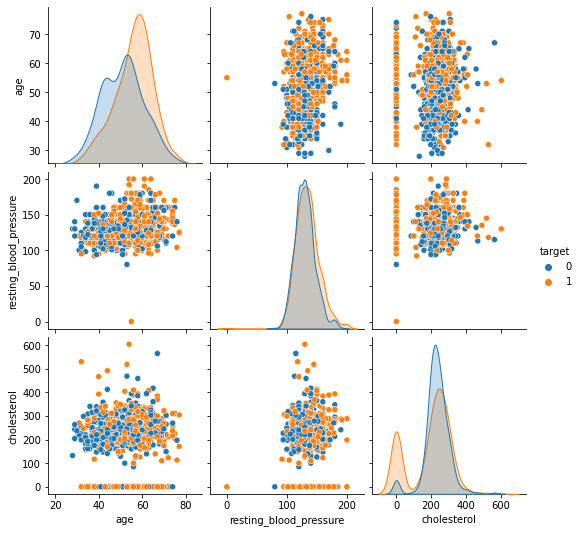

In [21]:
sns.pairplot(df, hue="target", vars=["age","resting_blood_pressure", "cholesterol"])

From above plot it is clear that as the age increases chances of heart disease increases

<AxesSubplot:xlabel='resting_blood_pressure', ylabel='cholesterol'>

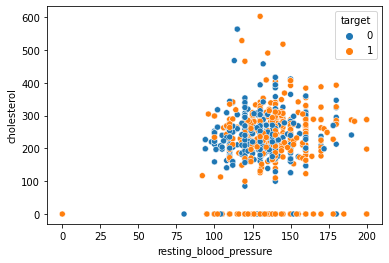

In [22]:
sns.scatterplot(data=df, x="resting_blood_pressure", y="cholesterol", hue="target")

From the above plot we can see outliers clearly as for some of the patients cholesterol is 0 whereas for one patient both cholesterol and resting bpp is 0 which may be due to missing entries we will filter these outliers later

<AxesSubplot:xlabel='resting_blood_pressure', ylabel='age'>

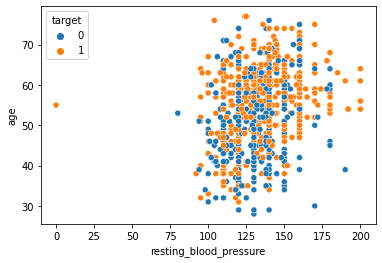

In [23]:
 sns.scatterplot(data=df, x="resting_blood_pressure", y="age", hue="target")

#### Outlier Detection and removal

In [24]:
#filtering numeric features as age, resting bp, cholesterol and max heart rate has outliers as per EDA

df_numeric=df[["age","resting_blood_pressure","cholesterol","max_heart_rate"]]

In [25]:
df_numeric.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate
0,40,140,289,172
1,49,160,180,156
2,37,130,283,98
3,48,138,214,108
4,54,150,195,122


In [26]:
#Calculating zscore of numeric columns in the dataset
z=np.abs(stats.zscore(df_numeric))
print(z)

           age  resting_blood_pressure  cholesterol  max_heart_rate
0     1.466266                0.428136     0.775228        1.264301
1     0.503599                1.517370     0.299516        0.637259
2     1.787155                0.116481     0.716067        1.635766
3     0.610562                0.319212     0.035725        1.243865
4     0.031216                0.972753     0.151616        0.695204
...        ...                     ...          ...             ...
1185  0.931451                1.205715     0.528727        0.303303
1186  1.528698                0.645983     0.171336        0.049408
1187  0.352105                0.116481     0.782658        0.969535
1188  0.352105                0.116481     0.252646        1.342681
1189  1.680192                0.319212     0.348816        1.303491

[1189 rows x 4 columns]


From these points it is difficult to say which points are outliers so we will now define threshold

In [27]:
#Define threshold for filtering outliers
threshold=3
print(np.where(z>3))

(array([  30,   76,  109,  149,  242,  366,  371,  391,  400,  450,  592,
        617,  733,  760, 1012, 1038, 1074], dtype=int64), array([2, 2, 1, 2, 1, 1, 3, 3, 1, 1, 1, 2, 1, 1, 1, 2, 1], dtype=int64))


The first array contains the list of row numbers and second array respective column numbers, which means z[30][2] have a z-score higher than 3. There are 17 data points which are outliers 

In [28]:
#filtering outliers retaining only those data points shich are below threshold
df=df[(z<3).all(axis=1)]

In [29]:
df=pd.get_dummies(df, drop_first=True, columns=['sex','chest_pain_type','rest_ecg','st_slope'], prefix=['s','pain','rest','slope'])

In [30]:
df.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate,exercise_angina,st_depression,target,s_male,pain_atypical_angina,pain_nonangnal_pain,pain_typical_angina,rest_left_ventricular_hypertrophy,rest_normal,slope_flat,slope_upsloping
0,40,140,289,0,172,0,0.0,0,1,1,0,0,0,1,0,1
1,49,160,180,0,156,0,1.0,1,0,0,1,0,0,1,1,0
2,37,130,283,0,98,0,0.0,0,1,1,0,0,0,0,0,1
3,48,138,214,0,108,1,1.5,1,0,0,0,0,0,1,1,0
4,54,150,195,0,122,0,0.0,0,1,0,1,0,0,1,0,1


In [31]:
X=df.drop(["target"], axis=1)
y=df["target"]

In [32]:
X.head()

,age,resting_blood_pressure,cholesterol,fasting_blood_sugar,max_heart_rate,exercise_angina,st_depression,s_male,pain_atypical_angina,pain_nonangnal_pain,pain_typical_angina,rest_left_ventricular_hypertrophy,rest_normal,slope_flat,slope_upsloping
0,40,140,289,0,172,0,0.0,1,1,0,0,0,1,0,1
1,49,160,180,0,156,0,1.0,0,0,1,0,0,1,1,0
2,37,130,283,0,98,0,0.0,1,1,0,0,0,0,0,1
3,48,138,214,0,108,1,1.5,0,0,0,0,0,1,1,0
4,54,150,195,0,122,0,0.0,1,0,1,0,0,1,0,1


#### Train Test Split

In [33]:
X_train, X_test, y_train, y_test=train_test_split(X,y,stratify=y,test_size=0.2, shuffle=True, random_state=22)

In [34]:
#CHecking distribution of target variable in train test split
print("Distribution of target variable in training set")
print(y_train.value_counts())

print("Distribution of target variable in test set")
print(y_test.value_counts())

Distribution of target variable in training set
1    491
0    446
Name: target, dtype: int64
Distribution of target variable in test set
1    123
0    112
Name: target, dtype: int64


##### feature normalization

In [35]:
scaler=StandardScaler()
X_train[["age","resting_blood_pressure","cholesterol","max_heart_rate","st_depression"]]=scaler.fit_transform(X_train[["age","resting_blood_pressure","cholesterol","max_heart_rate","st_depression"]])

In [36]:
X_test[["age","resting_blood_pressure","cholesterol","max_heart_rate","st_depression"]]=scaler.transform(X_test[["age","resting_blood_pressure","cholesterol","max_heart_rate","st_depression"]])

In [37]:
def GetBaseModel():
    baseModels=[]
    baseModels.append(('log_reg', LogisticRegression()))
    baseModels.append(('SVM', SVC()))
    baseModels.append(('Decision Tree', DecisionTreeClassifier()))
    baseModels.append(('RandomForest', RandomForestClassifier()))
    baseModels.append(('NaiveBayes', GaussianNB()))
    baseModels.append(('KNN', KNeighborsClassifier()))
    baseModels.append(('Ada', AdaBoostClassifier()))
    baseModels.append(('GradientBoost', GradientBoostingClassifier()))
    #baseModels.append(('XGB', XGBClassifier(eval_metric = 'logloss')))
    return baseModels

def BasedLine(X_train, y_train,models):
    num_folds = 10
    scoring = 'accuracy'
    results = []
    names = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    return results, msg

In [38]:
models=GetBaseModel()
names, results = BasedLine(X_train, y_train, models)

log_reg: 0.848490 (0.025827)
SVM: 0.871986 (0.024982)
Decision Tree: 0.871917 (0.033045)
RandomForest: 0.925326 (0.015705)
NaiveBayes: 0.831377 (0.030442)
KNN: 0.842096 (0.029151)
Ada: 0.853809 (0.018910)
GradientBoost: 0.891192 (0.022522)


#### XGB 

In [39]:
parameters = {
        'learning_rate':[0.01,0.025,0.1],
        'max_depth': [2,3, 5, 7, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7],
        'colsample_bytree': [0.5, 0.7],
        'n_estimators' : [10,20,50,100,150,200],
        'objective': ['reg:squarederror']
}
XGB=XGBClassifier()
grid_search=GridSearchCV(XGB, parameters, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_parameters=None,
                                     verbosity=None),
             par

In [40]:
grid_search.best_params_

{'colsample_bytree': 0.7,
 'learning_rate': 0.025,
 'max_depth': 10,
 'min_child_weight': 3,
 'n_estimators': 150,
 'objective': 'reg:squarederror',
 'subsample': 0.7}

In [41]:
XGB=XGBClassifier(colsample_bytree=0.7, learning_rate=0.025, max_depth=10,min_child_weight=3,n_estimators=150,
                  objective='reg:squarederror',subsample=0.7)
XGB.fit(X_train, y_train)
XGB_prediction=XGB.predict(X_test)

##### Random Forest

In [42]:
parameters = [
    {
        'max_depth': np.arange(1, 10),
        'min_samples_split': np.arange(2, 5),
        'random_state': [3],
        'n_estimators': np.arange(10, 20)
    },
]

RandomForest=RandomForestClassifier()
grid_search=GridSearchCV(RandomForest, parameters, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                          'min_samples_split': array([2, 3, 4]),
                          'n_estimators': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                          'random_state': [3]}],
             scoring='accuracy')

In [43]:
grid_search.best_params_

{'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 19, 'random_state': 3}

In [44]:
RandomForest=RandomForestClassifier(max_depth=9, min_samples_split=3, n_estimators=19, random_state=3)
RandomForest.fit(X_train, y_train)
forest_prediction=RandomForest.predict(X_test)

##### Gradient Boost

In [45]:
parameters = [
{
    'learning_rate': [0.01, 0.02, 0.002],
    'random_state': [0],
    'n_estimators': np.arange(3, 20)
    },
]

GradientBoost=GradientBoostingClassifier()
grid_search=GridSearchCV(GradientBoost, parameters, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=GradientBoostingClassifier(),
             param_grid=[{'learning_rate': [0.01, 0.02, 0.002],
                          'n_estimators': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]),
                          'random_state': [0]}],
             scoring='accuracy')

In [46]:
grid_search.best_params_

{'learning_rate': 0.02, 'n_estimators': 19, 'random_state': 0}

In [47]:
GradientBoost=GradientBoostingClassifier(learning_rate=0.02, n_estimators=19, random_state=0)
GradientBoost.fit(X_train, y_train)
GradientBoosting_prediction=GradientBoost.predict(X_test)

##### Support Vector Machine

In [48]:
parameters = {'C':[0.05,0.1,0.2,0.3,0.25,0.4,0.5,0.6,0.7,0.8,0.9,1],
         'gamma':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],
         'kernel':['rbf','linear']
        }


svm=SVC()
grid_search=GridSearchCV(svm, parameters, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.05, 0.1, 0.2, 0.3, 0.25, 0.4, 0.5, 0.6, 0.7,
                               0.8, 0.9, 1],
                         'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9,
                                   1.0],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy')

In [49]:
grid_search.best_params_

{'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}

In [50]:
svc=SVC(C=1, gamma=0.5, kernel='rbf')
svc.fit(X_train, y_train)
svm_prediction=svc.predict(X_test)

##### Model Evaluation

,Model,Accuracy,Precision,Sensitivity
0,RandomForest,0.902128,0.909836,0.902439


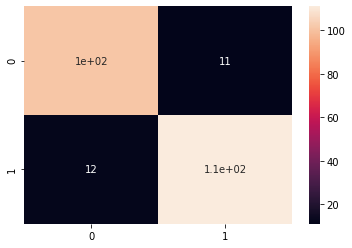

In [51]:
CM=confusion_matrix(y_test,forest_prediction)
sns.heatmap(CM, annot=True)

TN = CM[0][0]
FN = CM[1][0]
TP = CM[1][1]
FP = CM[0][1]

acc= accuracy_score(y_test, forest_prediction)
prec = precision_score(y_test, forest_prediction)
rec = recall_score(y_test, forest_prediction)
model_results =pd.DataFrame([['RandomForest',acc, prec,rec]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity'])

model_results

In [52]:
data={
    'XGB':XGB_prediction,
    'GradientBoosting':GradientBoosting_prediction,
    'svm':svm_prediction
}

models=pd.DataFrame(data)

for column in models:
    CM=confusion_matrix(y_test, models[column])
    
    TN=CM[0][0]
    FN=CM[1][0]
    TP=CM[1][1]
    FP=CM[0][1]
    
    acc= accuracy_score(y_test, models[column])
    prec = precision_score(y_test, models[column])
    rec = recall_score(y_test, models[column])
    
    results  =pd.DataFrame([[column,acc, prec,rec]],
               columns = ['Model', 'Accuracy','Precision', 'Sensitivity'])
    model_results=model_results.append(results, ignore_index=True)
    
model_results   

,Model,Accuracy,Precision,Sensitivity
0,RandomForest,0.902128,0.909836,0.902439
1,XGB,0.914894,0.912000,0.926829
2,GradientBoosting,0.795745,0.804878,0.804878
3,svm,0.897872,0.889764,0.918699


##### Model

In [53]:
#open a file, where you want to store the data
file=open("random_forest_model.pkl","wb")

#dump information into that file
pickle.dump(RandomForest, file)

In [54]:
pickle.dump(RandomForest, open('forest_model.pkl', 'wb'))

In [55]:
model = pickle.load(open('forest_model.pkl', 'rb'))